In [588]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import scipy.stats.distributions as dist

%matplotlib inline

# Step 0: Goal of the Project

The goal of this project is to explore the police complaints filed against NY Police Officers to see if there is a pattern in what kind of complaints are substantiated and to visualize some of the statistics. 
    
For example some topics I'm looking to explore:

    1. What is the average amount of complaints against a police officer?
    2. Is there a relationship between ethnicity and substantiated claims?
    3. Are certain type of allegations more likely to be substantiated?
    4. How many officers were promoted despite having a complaint against them?

These are some of the questions which first come to mind when looking at this data, and more questions may come up as I explore this data.

# Step 1: EDA

First, were going to make sure the dataset is cleaned, get a sense of how big it is, what the features are, and take a peek at a few summary statistics.

In [631]:
complaints = pd.read_csv('./data/allegations.csv')
     
print('Complaints Shape =', complaints.shape, '\n' ) #33358 different complaints
print('Complaints Columns:\n', pd.Series(complaints.columns.values), '\n') #Look at the different features of our dataset
print('NaN Values:\n', complaints.isnull().sum()[complaints.isnull().sum() > 0], '\n') #Check for NaN values
print('Unique Amount of Officers =', pd.unique(complaints['unique_mos_id']).size, '\n')
print('Mean number of complaints per officer =', round(33358/3996, 2), '\n')

complaints_clean = complaints.dropna()

print('Datatype of each feature:\n',complaints_clean.dtypes) #make sure each feature is what its supposed to be

complaints_clean.head()

Complaints Shape = (33358, 27) 

Complaints Columns:
 0                unique_mos_id
1                   first_name
2                    last_name
3                  command_now
4                    shield_no
5                 complaint_id
6               month_received
7                year_received
8                 month_closed
9                  year_closed
10         command_at_incident
11        rank_abbrev_incident
12             rank_abbrev_now
13                    rank_now
14               rank_incident
15               mos_ethnicity
16                  mos_gender
17            mos_age_incident
18       complainant_ethnicity
19          complainant_gender
20    complainant_age_incident
21                   fado_type
22                  allegation
23                    precinct
24              contact_reason
25         outcome_description
26           board_disposition
dtype: object 

NaN Values:
 command_at_incident         1544
complainant_ethnicity       4464
complainant_ge

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
5,10012,Paula,Smith,078 PCT,4021,37256,5,2017,10,2017,...,50,White,Male,31.0,Abuse of Authority,Refusal to process civilian complaint,78.0,C/V telephoned PCT,No arrest made or summons issued,Substantiated (Command Lvl Instructions)


Unfortunately, it looks like there is a lot of missing information about the complainant such as their ethnicity, gender, and age. However, it's not a significant amount of the data and about 86% of the complainant data is still in the dataset. It makes sense that some people may not be comfortable putting down their ethnicity or age in fear of being discriminated against. One surprising statistic already is that there are 33,358 complaints against only 3,996 officers.

I've also noticed that some of the complaint IDs appear more than once. I don't think these are duplicate complaints, but instead different complaints filed by the same person.

In [590]:
comuniq = pd.unique(complaints['complaint_id'])[0]
com = complaints.set_index('unique_mos_id')
com[com['complaint_id'] == comuniq][['complaint_id','month_received','month_closed',
                                     'complainant_ethnicity','complainant_gender','fado_type',
                                     'allegation']]

#see similarities in officer, date filed/closed, complainant ethnicity, gender, fado type
#a woman is filing a complaint against two different police officers here, probably from the same incident

,complaint_id,month_received,month_closed,complainant_ethnicity,complainant_gender,fado_type,allegation
unique_mos_id,,,,,,,
10004,42835,7,5,Black,Female,Abuse of Authority,Failure to provide RTKA card
9984,42835,7,5,Black,Female,Abuse of Authority,Failure to provide RTKA card
9984,42835,7,5,Black,Female,Abuse of Authority,Threat of summons
9984,42835,7,5,Black,Female,Abuse of Authority,Threat of arrest
9984,42835,7,5,Black,Female,Abuse of Authority,Property damaged


After looking at the head of the dataset, one feature which could be improved is the board disposition. This declares whether or not the complaint was substantiated which means proven to violate the rules. It also includes the type of discipline for the substantiated complaints which are described here: https://www1.nyc.gov/site/ccrb/prosecution/police-discipline.page. Splitting whether the complaint was substantiated and what discipline was enforced might make graphing easier later. 

In [632]:
#need to make copy because changing complaints_clean will change the entire dataset
complaints_copy = complaints.copy().dropna() 

board_disposition = complaints_copy['board_disposition']

#Grab all the entries with substantiated claims
substantiated_complaints = board_disposition[board_disposition.str.match('^Substantiated')]

#Split the punishments from the substantiation and get rid of parentheses, might use this later
punishments = substantiated_complaints.str.split(pat = '\(',expand=True).replace('\)',' ',regex=True)[1]

#Replace the board disposition column w/ just substantiated w/o the punishments
complaints_clean = complaints_clean.replace('\((.+)\)','',regex=True)
complaints_clean['board_disposition'] = complaints_clean['board_disposition'].str.strip()
complaints_clean.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated
5,10012,Paula,Smith,078 PCT,4021,37256,5,2017,10,2017,...,50,White,Male,31.0,Abuse of Authority,Refusal to process civilian complaint,78.0,C/V telephoned PCT,No arrest made or summons issued,Substantiated


I can also drop a few columns which may not help when looking at patterns of the complaints and officers. I'll drop the first and last names and just identify each officer by their MOS ID. I'll also drop the shield number because the MOS ID should be enough to identify the officers. Also dropping rank_now/incident because there is another column which just abbreviates it.

In [633]:
complaints_clean.drop(columns=['first_name', 'last_name', 'shield_no','rank_now', 'rank_incident'], inplace=True)
complaints_clean.head()

,unique_mos_id,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,078 PCT,42835,7,2019,5,2020,078 PCT,POM,POM,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated
1,10007,078 PCT,24601,11,2011,8,2012,PBBS,POM,POM,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated
2,10007,078 PCT,24601,11,2011,8,2012,PBBS,POM,POM,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated
3,10007,078 PCT,26146,7,2012,9,2013,PBBS,POM,POM,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated
5,10012,078 PCT,37256,5,2017,10,2017,078 PCT,SGT,SGT,...,50,White,Male,31.0,Abuse of Authority,Refusal to process civilian complaint,78.0,C/V telephoned PCT,No arrest made or summons issued,Substantiated


So the data looks like it's cleaned up now and has the most interesting features. The next step is to visualize some of these statistics.

# Step 3: Visualization and Analysis

## Investigating Question 1: How many complaints does each officer have?

The first thing I want to visualize is the amount of all complaints against each police officer. Since there are so many officers, I'll visualize ranges of complaints. So I'll look at how many officers have 0-10 complaints, 10-20, and so on.

  Range of Complaints  Amount of Officers in Complaint Range
0                0-10                                   2960
1               10-20                                    668
2               20-30                                    134
3               30-40                                     45
4               40-50                                      9
5               50-60                                      1
6               60-70                                      2
7               70-80                                      1


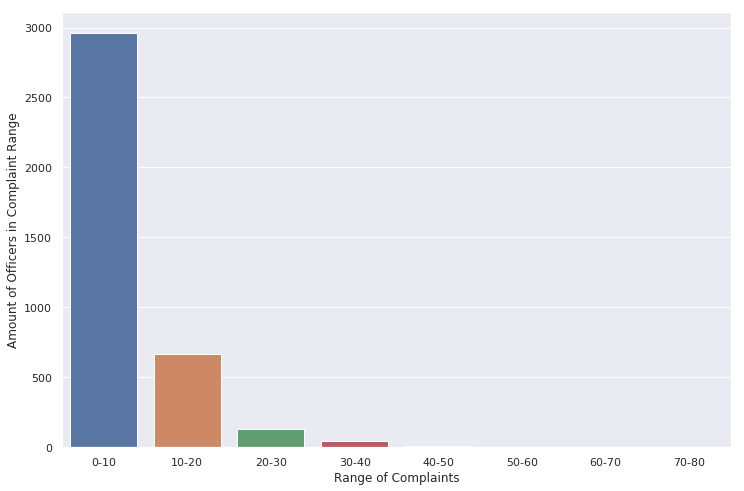

In [593]:
complaint_amt = complaints_clean['unique_mos_id'].value_counts()

#note: bins*increment should be > 80 to see all complaints
def split_complaints(value_counts, bins = 8, increment = 10):
    
    """Get the amount of complaints within each range.
    
        Args:
            value_counts: An array with the amount of complaints per officer.
            bins: How many bins to split up the complaints into. (int)
            increment: Range which falls into each bin. (int)
            
        Returns:
            complaints_per_range: A dataframe with the range labels and the amount of
            officers in each bin.
            
            """
    
    bin_range = np.arange(0,bins*increment, increment)

    complaints_per_range = [value_counts[(value_counts > i) & (complaint_amt <= (i+increment))].size
                          for i in bin_range]
    
    range_labels = ["{}-{}".format(bin_range[j], bin_range[j+1]) for j in range(len(bin_range)-1)]
    range_labels.append("{}-{}".format(bin_range[-1],bin_range[-1]+increment))
    
    
    complaint_df = pd.DataFrame({'Range of Complaints':range_labels,
                                 'Amount of Officers in Complaint Range':complaints_per_range})
    
    return complaint_df
    

complaints_range = split_complaints(complaint_amt)

print(complaints_range)

sns.set()
fig = plt.gcf()
fig.set_size_inches(12,8)
sns.barplot(x = "Range of Complaints", y = "Amount of Officers in Complaint Range", data = complaints_range,
           )

plt.show()

So we see that a majority of the officers fall within the 1-20 range while about 170 officers have recieved over 30 complaints. First, we'll look at the largest range and see what the distribution of complaints is per officer and understand these complaints in more detail.

In [594]:
#Making a copy since were going to be looking at a subset of the complaints_clean dataframe
first_range_df = complaints_clean.copy()

first_range = complaint_amt[complaint_amt <= 20].to_frame()
first_range = first_range.rename(columns={'unique_mos_id':'amount_of_complaints'})
first_range_df = first_range_df.join(first_range, on='unique_mos_id',how='inner')
first_range_df = first_range_df.set_index(['amount_of_complaints']).sort_index()
first_range_df

,unique_mos_id,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
amount_of_complaints,,,,,,,,,,,,,,,,,,,,,
1,10004,078 PCT,42835,7,2019,5,2020,078 PCT,POM,POM,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated
1,19282,DB SVD,12528,11,2006,7,2007,023 PCT,POF,DT3,...,26,Hispanic,Female,37.0,Abuse of Authority,Frisk,23.0,Other,No arrest made or summons issued,Substantiated
1,28094,PSA 1,33220,8,2015,12,2015,PSA 1,POM,POM,...,31,Black,Female,50.0,Abuse of Authority,Refusal to provide name/shield number,60.0,Report-domestic dispute,No arrest made or summons issued,Substantiated
1,32724,SVD Z2,26763,9,2012,7,2013,112 PCT,POM,DT3,...,40,Asian,Male,47.0,Abuse of Authority,Vehicle stop,112.0,C/V requested investigation of crime,No arrest made or summons issued,Substantiated
1,19303,DB SVD,24250,9,2011,5,2012,041 PCT,POM,DTS,...,29,Hispanic,Male,24.0,Force,Physical force,41.0,Other,Arrest - resisting arrest,Unsubstantiated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,16645,C R C,35926,10,2016,2,2017,042 PCT,POM,POM,...,30,Hispanic,Female,36.0,Abuse of Authority,Refusal to provide name/shield number,42.0,Moving violation,Moving violation summons issued,Unsubstantiated
20,16645,C R C,35509,7,2016,3,2017,042 PCT,POM,POM,...,30,Black,Female,15.0,Discourtesy,Word,42.0,Report of other crime,Arrest - other violation/crime,Unsubstantiated
20,16645,C R C,35509,7,2016,3,2017,042 PCT,POM,POM,...,30,Black,Female,41.0,Offensive Language,Race,42.0,Report of other crime,Arrest - other violation/crime,Unsubstantiated


    amount_of_complaints  unique_mos_id
0                      1            427
1                      2            457
2                      3            419
3                      4            355
4                      5            328
5                      6            270
6                      7            219
7                      8            205
8                      9            156
9                     10            124
10                    11            131
11                    12            110
12                    13             91
13                    14             63
14                    15             79
15                    16             59
16                    17             36
17                    18             33
18                    19             31
19                    20             35


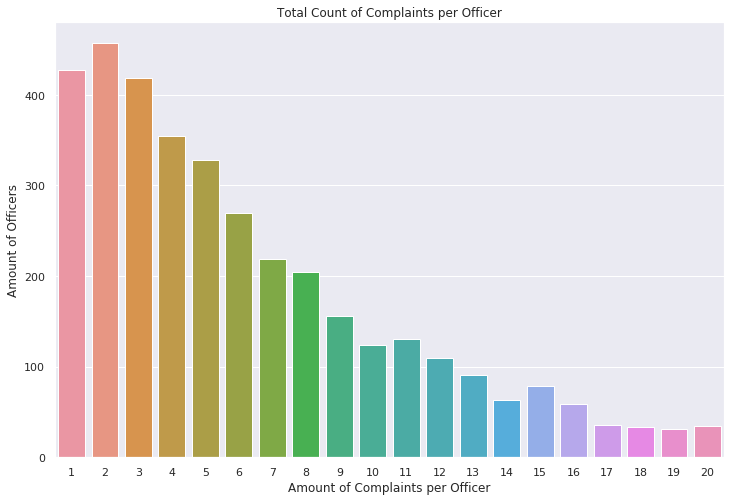

In [595]:
#Here I group by how many complaints for each officer while making sure it doesn't overcount
groupby_complaint_amt = first_range_df[['unique_mos_id']].groupby(['amount_of_complaints']).nunique().reset_index()
print(groupby_complaint_amt)

sns.set()
fig = plt.gcf()
fig.set_size_inches(12,8)
ax = sns.barplot(x = 'amount_of_complaints', y='unique_mos_id', data=groupby_complaint_amt)
ax.set(title='Total Count of Complaints per Officer',xlabel='Amount of Complaints per Officer',ylabel='Amount of Officers')
plt.show()

## Investigating Question 2: Links between Ethnicity and Substantiated Claims

Here we see that most officers have 2 complaints filed against them while there are at least 35 officers who have 20 against them. So a majority of the officers with complaints against them have at least 2. So now that we have an idea about how many complaints each officer has, lets look at some of the qualities of the complaints and some of the statistics surrounding ethnicity.

  complainant_ethnicity  Total Proportion of Population      Male    Female
0                 Black                        0.256564  0.219407  0.036773
1              Hispanic                        0.265310  0.230371  0.034556
2                 White                        0.303279  0.238136  0.064280
3               Unknown                        0.298220  0.246291  0.045994
4            Other Race                        0.279720  0.216783  0.059441
5                 Asian                        0.297917  0.277083  0.020833
6               Refused                        0.309859  0.248826  0.056338
7       American Indian                        0.415094  0.396226  0.018868


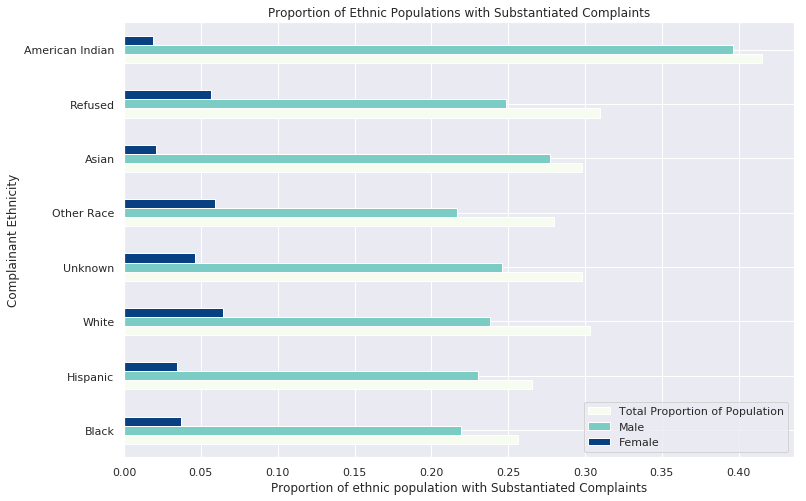

In [596]:
first_range_df['board_disposition'] = first_range_df['board_disposition'].str.strip()

ethnicity = first_range_df['complainant_ethnicity'].value_counts()

#Group the genders for all ethnicities
gender = first_range_df[['complainant_ethnicity',
                         'complainant_gender']
                        ].reset_index(
                        ).drop(columns='amount_of_complaints'
                        ).groupby('complainant_ethnicity'
                        )

#Group the genders for all ethnicities and filter whether claim was substantiated or not
substantiated_gender = first_range_df[['complainant_ethnicity','complainant_gender']
                                      ].where(first_range_df['board_disposition'] == 'Substantiated'
                                      ).dropna().reset_index(
                                      ).drop(columns='amount_of_complaints'
                                      ).groupby('complainant_ethnicity')


#Get the counts for male and female for all ethnicities
gender_count = []
gender_sub_count = []

for name, group in gender:
    
    Male = len(group[group['complainant_gender'] == 'Male'])
    Female = len(group[group['complainant_gender'] == 'Female'])
    gender_count.append((name, Male, Female))

for name, group in substantiated_gender:
    
    Male = len(group[group['complainant_gender'] == 'Male'])
    Female = len(group[group['complainant_gender'] == 'Female'])
    gender_sub_count.append((name, Male, Female))

gender_df = pd.DataFrame(list(gender_count)).set_index(0)
gender_df = gender_df.rename(columns={1:'Male',2:'Female'})

gender_sub_df = pd.DataFrame(list(gender_sub_count)).set_index(0)
gender_sub_df = gender_sub_df.rename(columns={1:'Male',2:'Female'})

#Filter the ethnicities with substantiated complaints
substantiated_ethnicity = first_range_df['complainant_ethnicity'].where(first_range_df['board_disposition'] 
                                                      == 'Substantiated').dropna()

#Get the counts for amount of substantiated complaints per ethnicity
sub_eth_counts = substantiated_ethnicity.value_counts()

#Look at the proportion of the populations which have substantiated claims since they all have different pops.
sub_eth_counts_proportional = sub_eth_counts/ethnicity
sub_eth_counts_proportional = sub_eth_counts_proportional.reset_index()
sub_eth_counts_proportional = sub_eth_counts_proportional.rename(columns={
    'index':'complainant_ethnicity','complainant_ethnicity':'value_counts'})

#Take the proportion of the gender population for each ethnicity
gender_sub_df['Male'] = gender_sub_df['Male']/ethnicity
gender_sub_df['Female'] = gender_sub_df['Female']/ethnicity
gender_sub_df = gender_sub_df.rename(columns={0:'complainant_ethnicity'})

#Join the dataframes together
gender_eth_df = sub_eth_counts_proportional.join(gender_sub_df, on='complainant_ethnicity')
gender_eth_df = gender_eth_df.rename(columns={'value_counts':'Total Proportion of Population'})
print(gender_eth_df)

#Plot the dataframe
ax = gender_eth_df.plot(x='complainant_ethnicity',kind='barh', figsize=(12,8), colormap='GnBu')
ax.set(ylabel ='Complainant Ethnicity' , xlabel='Proportion of ethnic population with Substantiated Complaints',
       title='Proportion of Ethnic Populations with Substantiated Complaints')
plt.show()

Looking at this bar graph it appears that American Indian's complaints are the most substantiated while the lowest is for Black people. However, due to the different sample sizes of each ethnicity it is hard to compare them. It does seem that White people have the most amount of substantiated complaints as well against Black and Hispanic people. 

### Hypothesis Testing the significance that White people have more Substantiated Claims

In [ ]:
To investigate this, I am going to do a hypothesis test and look at the difference in proportions. My null hypothesis says that the two population proportions of substantiated claims are the same and it is not significant that White people have more substantiated complaints. My alternative hypothesis says that the two population proportions are not equal and it is significant that White people have more substantiated complaints.

Ho: p1 - p2 = 0 

Ha: p1 - p2 != 0

where p1 is the population proportion of White people and p2 is the population proportion of Black People


In [597]:
#Calculated population proportions
p1 = gender_eth_df.loc[2,('Total Proportion of Population')]
p2 = gender_eth_df.loc[0,('Total Proportion of Population')]

diff = p1 - p2

n1 = ethnicity['White']
n2 = ethnicity['Black']

p1_tot = p1*n1
p2_tot = p2*n2

p = (p1_tot + p2_tot)/(n1 + n2)

se = np.sqrt(p*(1-p)*((1/n1)+(1/n2)))

test_stat = diff/se
print('T-stat:',test_stat)

pvalue = 2*dist.norm.cdf(np.abs(test_stat))
print('P-Value:',pvalue)

T-stat: 4.703353694669584
P-Value: 1.9999974407749501


Since the p-value is much greater than 0.05 and even a relaxed threshold of 0.1, then we can see that it is not statistically significant that White people have more substantiated complaints for their proportion of population. This imbalance may be a result from more Black people being stopped by police which results in more complaints, and due to more complaints, the amount which has been substantiated is lower. This is just one idea which may explain the imbalance, but it is hard to compare these two populations when there are 11,000 more complaints from Black people which gives a more representative sample size.

## Investigating Question 3: Looking for Patterns between Substantiation and Allegation Type

Next, we will look at the different types of allegations which were substantiated. I want to see if there is a pattern in the types of allegations which officers were punished for. After this, we will look at the officer who have over 20 complaints to see what kind of complaints they have against them, and how many of these are substantiated complaints.

One thing to note is that I am analyzing a dataset without 5,346 complaints due to these rows missing some kind of data such as complainant ehtnicity, gender, or command at incident.

In [598]:
fado_count = complaints_clean['fado_type'].value_counts()
fado_count_tot = complaints['fado_type'].value_counts()
print('Summary of Allegation Counts:\n',fado_count,'\n')
print('Summary of Total Allegation Counts:\n',fado_count_tot)

Summary of Allegation Counts:
 Abuse of Authority    16668
Force                  6610
Discourtesy            4103
Offensive Language      631
Name: fado_type, dtype: int64 

Summary of Total Allegation Counts:
 Abuse of Authority    20292
Force                  7636
Discourtesy            4677
Offensive Language      753
Name: fado_type, dtype: int64


We see that most of the allegation counts come from abuse of authority and force. First, we'll look at which of these complaints are substantiated first and if it skews towards one type of allegation. Considering abuse of authority has the most amount of allegations, then the data may not be representative of each category. 

Looking at this also raises another question: are these allegations evenly spread out among all of the officers with complaints or is there a small population of officers with these complaints?

                    Substantiated  Exonerated  Unsubstantiated
fado_type                                                     
Abuse of Authority           5201        4254             7213
Discourtesy                   868         207             3028
Force                         728        3195             2687
Offensive Language             99           1              531


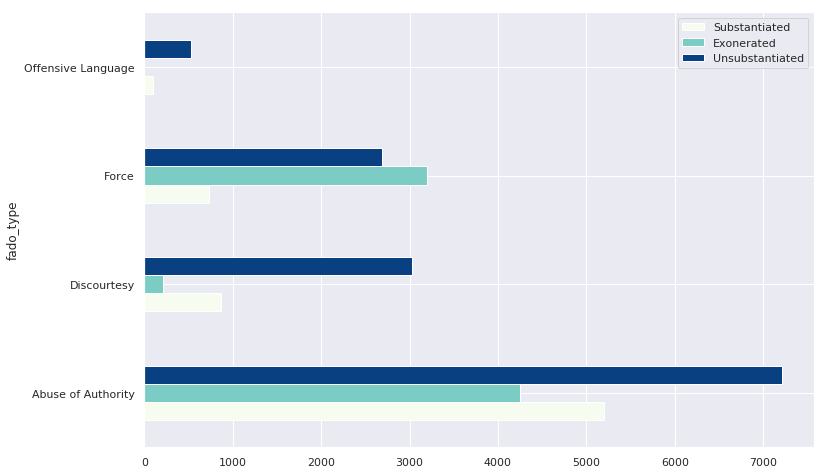

In [628]:
fado_grouping = complaints_clean[['board_disposition','fado_type']].astype('category')


sub_fado_grouping = fado_grouping[fado_grouping['board_disposition'] == 'Substantiated'
                                 ].groupby('fado_type').size().to_frame().rename(columns = {0:'Substantiated'})


exon_fado_grouping = fado_grouping[fado_grouping['board_disposition'] == 'Exonerated'
                                 ].groupby('fado_type').size().to_frame().rename(columns = {0:'Exonerated'})

unsub_fado_grouping = fado_grouping[fado_grouping['board_disposition'] == 'Unsubstantiated'
                                 ].groupby('fado_type').size().to_frame().rename(columns = {0:'Unsubstantiated'})


fado_df = pd.merge(sub_fado_grouping,exon_fado_grouping,left_index=True, right_index=True)
fado_df = pd.merge(fado_df, unsub_fado_grouping,left_index=True, right_index=True)
print(fado_df)

fado_df.plot(kind='barh',figsize=(12,8), colormap='GnBu')
plt.show()

#FIX THE PLOT AXES NAMES

Interestingly, many of the force complaints were exonerated. This means that the alleged conduct occurred, but it did not violate NYPD's rules. This shows that the discretion which NYPD has when judging use of force complaints. This shows that despite a use of force incident happening, 51% of the incidents resulted in the NYPD deciding that the incident did not violate their rules.

Now we will see how many officers who are repeat offenders for a certain type of allegation. This should raise some flags if the same officer has had multiple complaints of the same type against them.

               Abuse of Authority  Discourtesy  Offensive Language  Force
unique_mos_id                                                            
2                             8.0          1.0                 1.0    0.0
5                             1.0          1.0                 0.0    0.0
11                            2.0          1.0                 0.0    2.0
21                            3.0          4.0                 0.0    1.0
23                            7.0          0.0                 0.0    4.0
...                           ...          ...                 ...    ...
36301                         3.0          0.0                 0.0    0.0
36305                         3.0          0.0                 0.0    0.0
36317                         2.0          0.0                 0.0    0.0
36339                         2.0          0.0                 1.0    0.0
36374                         7.0          2.0                 0.0    2.0

[3820 rows x 4 columns]


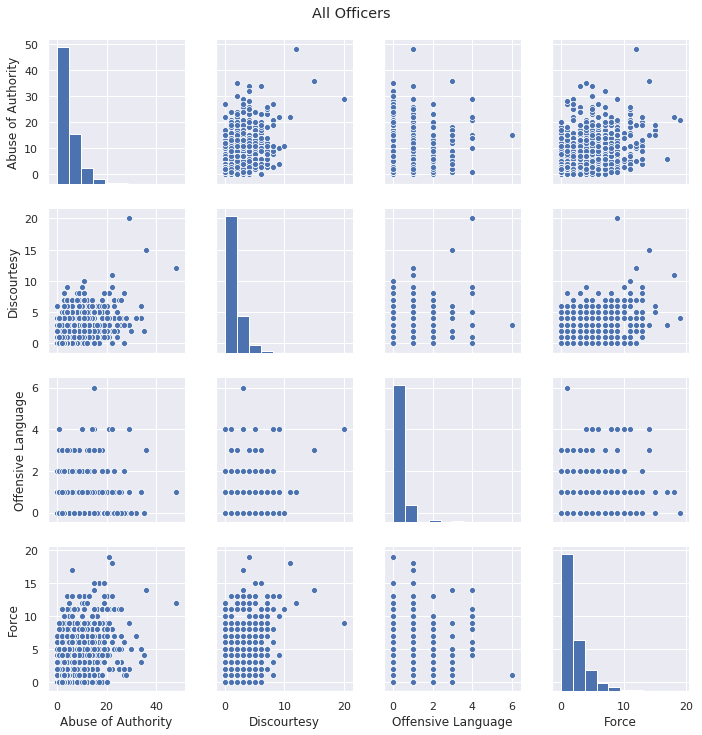

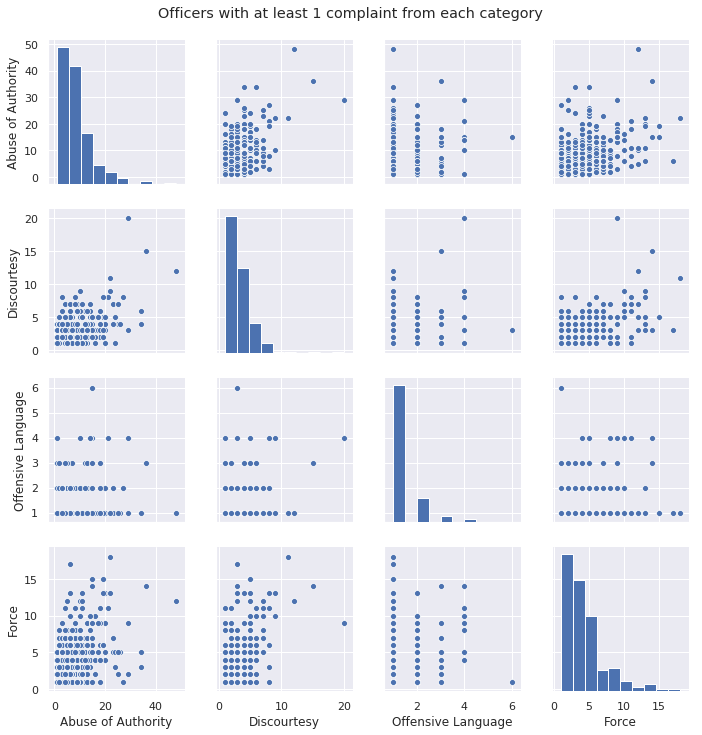

In [728]:
fado_mos_group = complaints_clean[['unique_mos_id', 'fado_type', 'allegation']]


old = [fado_mos_group[fado_mos_group['fado_type'] == fadotype
                                 ].groupby('unique_mos_id').size(
                                 ).to_frame().rename(columns = {0:fadotype}) 
       for fadotype in fado_mos_group['fado_type'].unique()]

fado_count_df = old[0].join(old[1], how='outer').join(old[2], how = 'outer').join(old[3], how='outer')
fado_count_df = fado_count_df.fillna(0)


print(fado_count_df)
all_count = fado_count_df.where(fado_count_df[['Force','Abuse of Authority','Discourtesy', 'Offensive Language']] > 0).dropna()

sns.set()

ax1 = sns.pairplot(fado_count_df)
ax2 = sns.pairplot(all_count)

ax1.fig.suptitle('All Officers', y=1.02)
ax2.fig.suptitle('Officers with at least 1 complaint from each category', y=1.02)


plt.show()

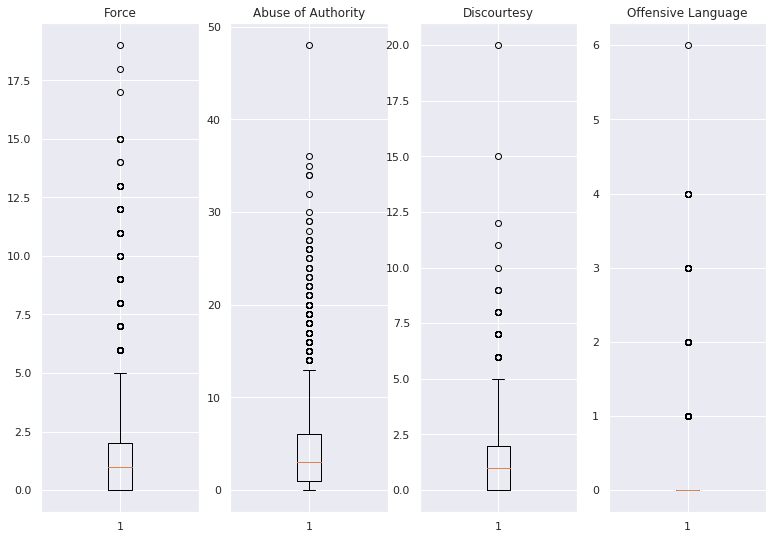

In [743]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(13, 9))


ax1.set_title('Force')
ax2.set_title('Abuse of Authority')
ax3.set_title('Discourtesy')
ax4.set_title('Offensive Language')

ax1.boxplot(fado_count_df['Force'])
ax2.boxplot(fado_count_df['Abuse of Authority'])
ax3.boxplot(fado_count_df['Discourtesy'])
ax4.boxplot(fado_count_df['Offensive Language'])
plt.show()

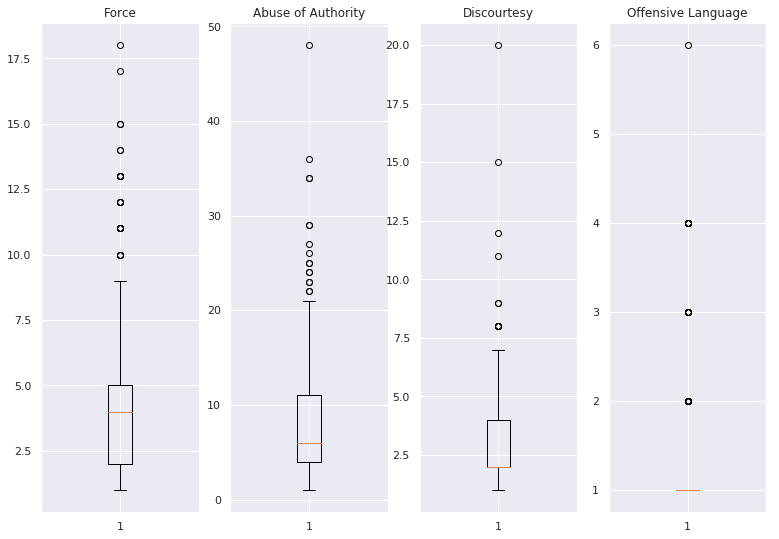

In [744]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(13, 9))


ax1.set_title('Force')
ax2.set_title('Abuse of Authority')
ax3.set_title('Discourtesy')
ax4.set_title('Offensive Language')

ax1.boxplot(all_count['Force'])
ax2.boxplot(all_count['Abuse of Authority'])
ax3.boxplot(all_count['Discourtesy'])
ax4.boxplot(all_count['Offensive Language'])
plt.show()

It appears that many officers are repeat offenders and some of the complaints may even be correlated when looking at the pair plot. There is a slight positive correlation between abuse of authority and use of force. When looking at the box plots, we can see the distribution of the amount of complaints against each officer. The upper quartile of force and discourtesy sit around 2 while abuse of authority sits at about 7.

I chose to also plot all of the officers with at least one complaint from each category as well because these are officers who are repeat offenders. They have a minimum of 4 complaints against each of them. I wanted to see if this subset of officers would have a different distribution of complaints compared to the rest of the officers. Of course the average probably rose due to the absence of 0 entries, but it is still surprising to see that the mean number of force complaints for each officer rose to 4.

Now we will look at who makes up the complaints for each category.

### Looking at Statistics of Abuse of Authority Complaints

Number of Officers with Abuse of Authority Complaints: 2788
2.0     596
3.0     468
4.0     397
5.0     285
6.0     238
7.0     152
8.0     134
9.0     104
10.0     90
11.0     75
12.0     55
13.0     36
14.0     25
16.0     22
15.0     22
19.0     15
18.0     13
17.0     11
20.0     10
21.0      6
22.0      5
26.0      5
23.0      4
24.0      4
25.0      3
27.0      3
29.0      2
34.0      2
32.0      1
36.0      1
35.0      1
30.0      1
28.0      1
48.0      1
Name: Abuse of Authority, dtype: int64
1327


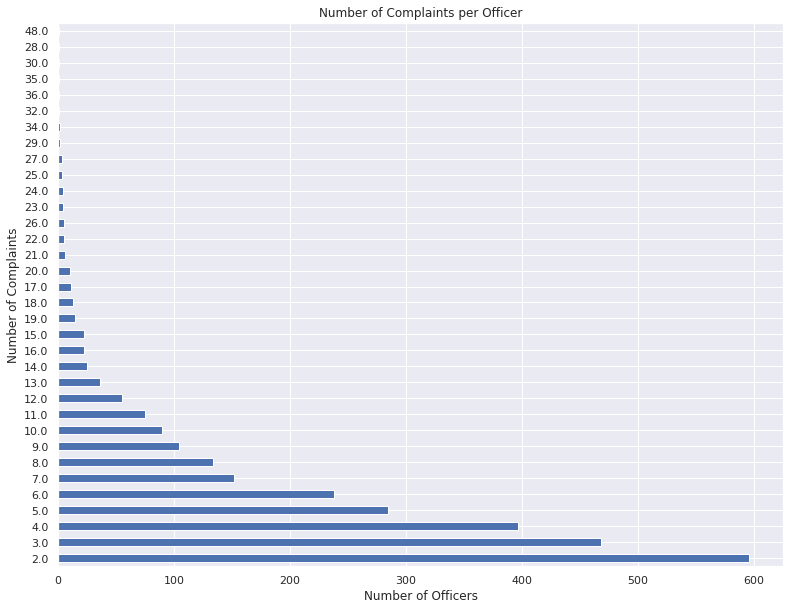

In [776]:
abuse_of_auth = fado_count_df[fado_count_df['Abuse of Authority'] > 1
                             ]['Abuse of Authority'].sort_values(ascending=False)
print('Number of Officers with Abuse of Authority Complaints:', abuse_of_auth.size)
ax = abuse_of_auth.value_counts().plot(kind='barh',figsize=(13,10))
ax.set(xlabel = 'Number of Officers', ylabel = 'Number of Complaints', title='Number of Complaints per Officer')
print(abuse_of_auth.value_counts())
plt.plot()

print(abuse_of_auth.value_counts()[abuse_of_auth.value_counts().index >= 5].sum())

The minimum amount of abuse of authority complaints for all officers is 2 while one officer has 48 complaints filed against them, yet they are still on the force. 50% of the people who have an abuse of authority complaint filed against them have at least 5 complaints. All of these officers are still working despite having 5 or more complaints filed against them in just the abuse of authority category.

This subset of police also have an average of 2.8 use of force complaints against them.

### Distribution in each Complaint Category

Abuse of Authority    8.862849
Discourtesy           1.729465
Offensive Language    0.287867
Force                 2.844763
dtype: float64


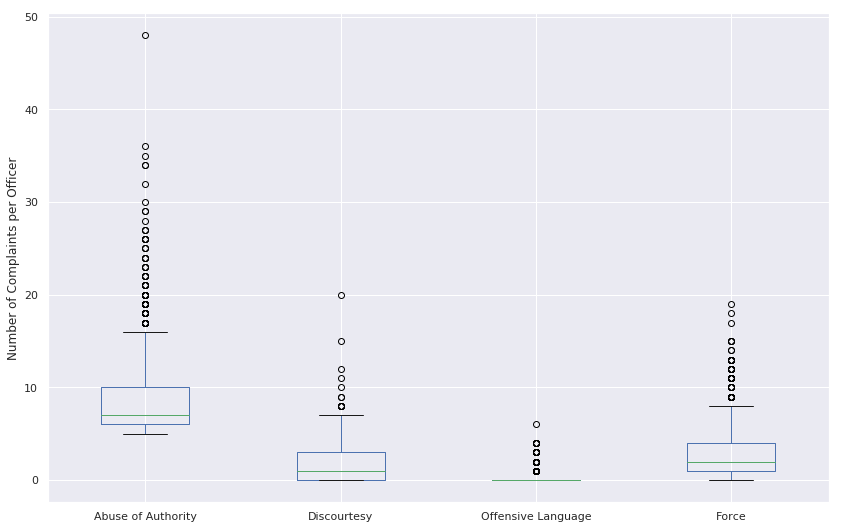

In [816]:
more = abuse_of_auth.where(abuse_of_auth >= 5).dropna()

subset = fado_count_df[fado_count_df.index.isin(more.index)]
print(subset.mean())
ax = subset.plot(kind='box',figsize=(14,9))
ax.set(ylabel='Number of Complaints per Officer')
plt.show()

Now that we've taken a deeper look into the type of complaints each officer has and the amount that each officer has, let's look at how many officers were actually promoted despite having complaints against them. For this, I will use the entire complaints dataset because I am interested in looking at the amount of complaints filed against the officers and less in the qualities of the complainants.

## Investigating Question 4: How many officers received a promotion despite having complaints?

In [860]:
complaints_rank = complaints.copy()

#rank rating based on CCRB Data Layout Table
rank_rating = {'POM':1, 'POF':1, 'DT3':6, 'LT':10, 'CPT':13,'DTS':9,'SSA':4,
               'LSA':11,'DT2':7,'DT1':8,'DI':17,'INS':18,'SDS':5,'LCD':12,'DC':19,
               'DET':7,'SGT':3,'CPT':13, 'AC':20, 'CD':24, 'COI':27, 'CCC':21,'PO':1}

def rank_convert(rank):
    
    return rank_rating[rank]

complaints_rank['rank_abbrev_incident'] = complaints['rank_abbrev_incident'].apply(rank_convert)
complaints_rank['rank_abbrev_now'] = complaints['rank_abbrev_now'].apply(rank_convert)

rank_up = complaints_rank.where(complaints_rank['rank_abbrev_now'] > complaints_rank['rank_abbrev_incident']).dropna()

rank_up_mos_grouping = rank_up.groupby('unique_mos_id').size().sort_values(ascending=False)
print(rank_up_mos_grouping)

unique_mos_id
18731.0    66
25814.0    57
18589.0    46
25785.0    43
27505.0    40
           ..
35820.0     1
26766.0     1
23589.0     1
19801.0     1
33894.0     1
Length: 1931, dtype: int64


It appears that there are 1931 unique officers who received a promotion despite having a complaint filed against them. Once officer has 66 complaints filed against him and still received a promotion. I guess getting complaints filed against you will land you a promotion. We will take a closer look at this officer.

In [879]:
most_complaints = complaints_rank[complaints_rank['unique_mos_id'] == 18731]

most_complaints.sort_values(by='year_received',ascending=False)


,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
7912,18731,Daniel,Sbarra,DB CEIS,0,25825,5,2012,7,2013,...,36,Black,Male,49.0,Abuse of Authority,Frisk,77.0,Other,No arrest made or summons issued,Substantiated (Charges)
7911,18731,Daniel,Sbarra,DB CEIS,0,25825,5,2012,7,2013,...,36,Black,Male,49.0,Abuse of Authority,Stop,77.0,Other,No arrest made or summons issued,Substantiated (Charges)
7920,18731,Daniel,Sbarra,DB CEIS,0,22856,3,2011,11,2011,...,35,Black,Male,53.0,Discourtesy,Word,81.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Unsubstantiated
7909,18731,Daniel,Sbarra,DB CEIS,0,22996,4,2011,6,2012,...,35,Black,Male,46.0,Abuse of Authority,Search (of person),81.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
7910,18731,Daniel,Sbarra,DB CEIS,0,22996,4,2011,6,2012,...,35,Black,Male,46.0,Abuse of Authority,Stop,81.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7853,18731,Daniel,Sbarra,DB CEIS,0,8351,10,2004,7,2005,...,28,Black,Male,28.0,Abuse of Authority,Search (of person),83.0,Other,No arrest made or summons issued,Substantiated (Charges)
7854,18731,Daniel,Sbarra,DB CEIS,0,8351,10,2004,7,2005,...,28,Black,Male,28.0,Offensive Language,Race,83.0,Other,No arrest made or summons issued,Substantiated (Charges)
7855,18731,Daniel,Sbarra,DB CEIS,0,8351,10,2004,7,2005,...,28,Black,Male,28.0,Abuse of Authority,Vehicle search,83.0,Other,No arrest made or summons issued,Substantiated (Charges)
7847,18731,Daniel,Sbarra,DB CEIS,0,6832,9,2003,2,2004,...,27,Hispanic,Male,39.0,Force,Physical force,83.0,Other,No arrest made or summons issued,Exonerated


This officer has complaints spanning almost a decade, yet still received a promotion from Sergeant to Lieutenant. Many of the complaints were even substantiated. In total he has 75 complaints spanning over a decade which is about 7.5 every year. In any other profession, receiving 75 complaints would not result in a promotion.

In [859]:
complaints_rank['rank_difference'] = complaints_rank['rank_abbrev_now'] - complaints_rank['rank_abbrev_incident']


complaints_rank.where(complaints_rank['rank_difference'] >= 10).dropna().groupby('unique_mos_id').size().sort_values(ascending=False)


unique_mos_id
27505.0    40
18589.0    35
14714.0    30
11318.0    28
10379.0    26
           ..
17315.0     1
21767.0     1
17117.0     1
15659.0     1
18460.0     1
Length: 101, dtype: int64

Here we see an officer with 40 complaints filed against them yet still rose 10 ranks.

In [888]:
#print(complaints_rank[complaints_rank['rank_abbrev_now'] == complaints_rank['rank_abbrev_now'].max()])
print(complaints_rank['rank_abbrev_now'].max())
display(complaints_rank[complaints['unique_mos_id'] == 22635].sort_values(by='year_received',ascending=False))


27


,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
13438,22635,Thomas,Galati,INT BUR,0,5409,4,2002,5,2003,...,37,NaN,NaN,NaN,Abuse of Authority,Premises entered and/or searched,47.0,Execution of search warrant,No arrest made or summons issued,Exonerated
13439,22635,Thomas,Galati,INT BUR,0,5756,8,2002,11,2003,...,38,NaN,NaN,NaN,Abuse of Authority,Premises entered and/or searched,47.0,Other violation of VTL,No arrest made or summons issued,Exonerated
13440,22635,Thomas,Galati,INT BUR,0,5746,8,2002,11,2003,...,38,NaN,NaN,NaN,Abuse of Authority,Premises entered and/or searched,47.0,Execution of search warrant,No arrest made or summons issued,Unsubstantiated
13434,22635,Thomas,Galati,INT BUR,0,4731,3,2001,10,2001,...,36,Black,Male,36.0,Abuse of Authority,Vehicle search,47.0,Other,Arrest - other violation/crime,Exonerated
13435,22635,Thomas,Galati,INT BUR,0,4731,3,2001,10,2001,...,36,Black,Male,36.0,Abuse of Authority,Strip-searched,47.0,Other,Arrest - other violation/crime,Exonerated
13436,22635,Thomas,Galati,INT BUR,0,4862,5,2001,2,2002,...,36,Black,Male,24.0,Abuse of Authority,Frisk and/or search,47.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Unsubstantiated
13437,22635,Thomas,Galati,INT BUR,0,4862,5,2001,2,2002,...,36,Black,Male,24.0,Abuse of Authority,Question and/or stop,47.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Unsubstantiated
13433,22635,Thomas,Galati,INT BUR,0,2146,12,1995,12,1995,...,31,NaN,NaN,NaN,Abuse of Authority,Person Searched,112.0,Stop/Question/Frisk,No arrest made or summons issued,Exonerated
13431,22635,Thomas,Galati,INT BUR,0,1595,4,1994,4,1994,...,29,NaN,NaN,NaN,Abuse of Authority,Person Searched,73.0,Traffic Incidents/Accident/Prk Violation,No arrest made or summons issued,Substantiated (No Recommendations)
13432,22635,Thomas,Galati,INT BUR,0,1595,4,1994,4,1994,...,29,NaN,NaN,NaN,Force,Punch/Kick,73.0,Traffic Incidents/Accident/Prk Violation,No arrest made or summons issued,Substantiated (No Recommendations)


This officer is now the Chief of Intelligence despite having 14 complaints filed against him. Interestingly, many of the complaints were exonerated which means that the conduct occurred, but did not seem to violate the NYPD's rules.

# Conclusion

In summary, we managed to answer all of the questions posed and take a deeper look into the data. We found that for all the officers who have complaints filed against them, the average amount is 2. We also found that one officer has 77 complaints filed against them. We saw that around 200 officers have 20 or more complaints filed against them. This is only counting the "clean" data as well since 4812 complaints were dropped when making those statistics. Interestingly, only 3,996 officers make up the 33,358 complaints. According to Wikipedia, as of 2018 there are 38,422 officers sworn in. This means that only 10% of the police force makes up all of the complaints which are filed. 

We found that there is no significant link between ethnicity and substantiated complaints or if we were to look into it more then we would need more data. It appears that more white people have more substantiated complaints, however the sample sizes are skewed since Black people have 11,000 more complaints filed. This also raises the question about why Black people would have 11,000 more complaints than White people? Perhaps more Black people are stopped by police which results in more complaints. This is just an idea.

For the third question, we found that ceratain type of allegations are not more likely to be substantiated, but use of force complaints are more likely to be exonerated. This is a sign of how the police force has the power to decide whether or not these cases violate their rules.

For the fourth question, we saw that almost 50% of officers who had a complaint filed against them received a promotion. The most egregious example is an officer with 77 complaints against them, yet still rising to 10 ranks higher than when they first received a complaint.

I would also like to thank and credit ProPublica for posting this dataset and the CCRB for accumulating these records over the years. 

You can find the link to the dataset here: https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers